In [1]:
%load_ext autoreload
%autoreload 2

import csv
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.special import binom
import scipy.stats as st
from scipy.stats import pearsonr, spearmanr, kendalltau
import seaborn as sns

# with open('data.json', 'w') as f:
#     json.dump(data, f)


### *ROCStory dataset*

In [2]:
with open('data.json') as f:
    data_dict = json.load(f)

# Create a list of dictionaries
# We take the hypothesis that the first 5 workers are the same because we do not have the data of the workers
rows = []
for key, value in data_dict.items():
    for model, model_data in value['gen'].items():
        for i in range(5):
            row = {
                'Story ID': key,
                'Prompt': value['prompt'],
                'Human': value['gold_response'],
                'Story': model_data['text'],
                'Model': model,
                'Overall Quality': model_data['score'][i],
                'Worker ID': i,
            }
            rows.append(row)


# Convert list of dictionaries to DataFrame
ROC_data = pd.DataFrame(rows)

In [3]:
ROC_data.Model.unique()

array(['fusion', 's2s', 'gpt_kg', 'gpt', 'plan_write'], dtype=object)

### *Dataset Analysis*

Text(0.5, 1.0, 'Worker scores distribution')

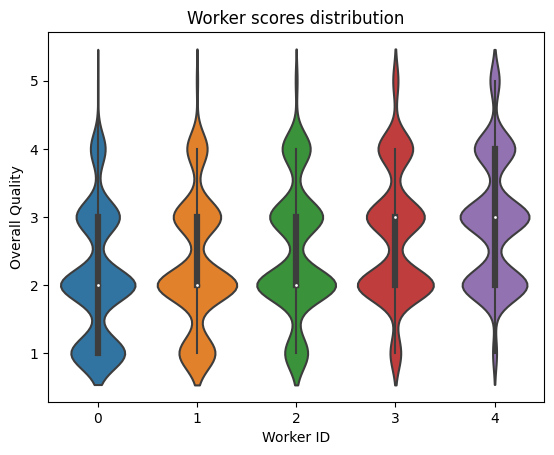

In [4]:
sns.violinplot(data=ROC_data, y="Overall Quality", x="Worker ID",cmap='icefire')
plt.title("Worker scores distribution")

Text(0.5, 1.0, 'Correlation between workers')

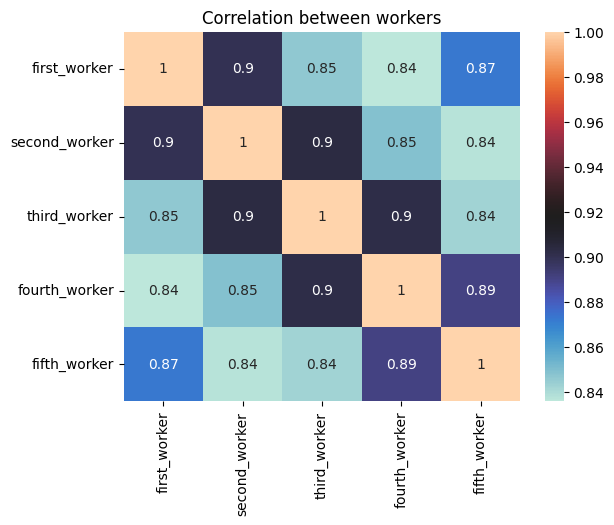

In [5]:
# study the correlation of the scores of the two workers
first_worker=ROC_data[ROC_data["Worker ID"] == 0]['Overall Quality'].reset_index(drop=True)
second_worker=ROC_data[ROC_data["Worker ID"] == 1]['Overall Quality'].reset_index(drop=True)
third_worker=ROC_data[ROC_data["Worker ID"] == 2]['Overall Quality'].reset_index(drop=True)
fourth_worker=ROC_data[ROC_data["Worker ID"] == 3]['Overall Quality'].reset_index(drop=True)
fifth_worker=ROC_data[ROC_data["Worker ID"] == 4]['Overall Quality'].reset_index(drop=True)
df=pd.DataFrame({'first_worker': first_worker, 'second_worker': second_worker, 'third_worker': third_worker, 'fourth_worker': fourth_worker, 'fifth_worker': fifth_worker})
# calculate the correlation matrix between two vectors
corr =df.corr(method='spearman')
# plot the heatmap
sns.heatmap(corr, annot=True, cmap='icefire')
plt.title("Correlation between workers")



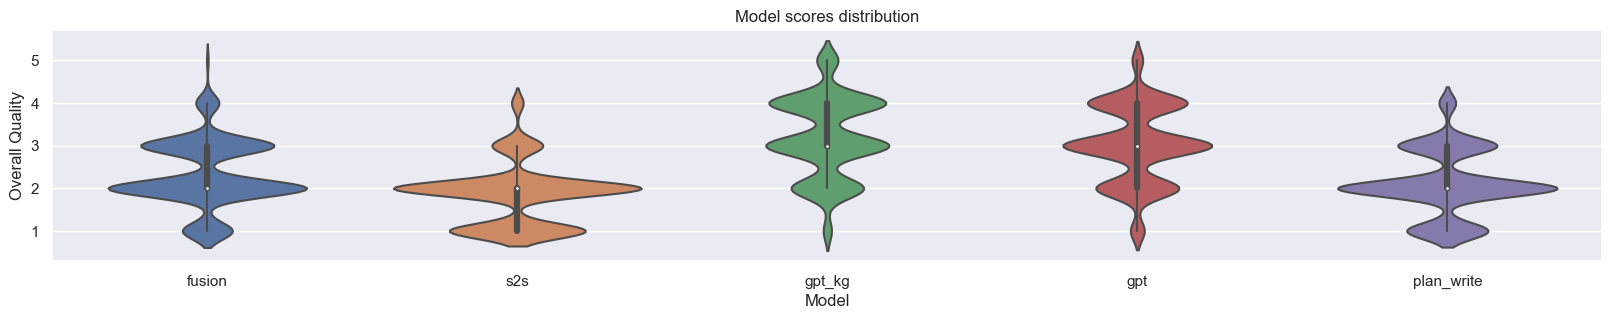

In [6]:

sns.set(rc={"figure.figsize":(20, 3)})
ax = sns.violinplot(x="Model", y='Overall Quality', data=ROC_data)
plt.title("Model scores distribution")
plt.show()

In [7]:
ROC_data.columns

Index(['Story ID', 'Prompt', 'Human', 'Story', 'Model', 'Overall Quality',
       'Worker ID'],
      dtype='object')

Installed gits:
for Depthscore, baryscore and infoLm : # !pip install git+https://github.com/PierreColombo/nlg_eval_via_simi_measures.git
for bert score # !pip install git+https://github.com/Tiiiger/bert_score.git


In [9]:
#  !pip install git+https://github.com/yuhui-zh15/nlg_metrics.git 

Calculate AEM for RocStories dataset

In [25]:
from metrics import ROUGE, BLUE, METEOR, DepthScore, BaryScore, InfoLM,WER, BertScore
Evaluated_df=ROC_data.copy()
# get the first 50 stories
Evaluated_df=Evaluated_df[Evaluated_df['Story ID'].astype(int) < 50]

Evaluated_df=Evaluated_df.groupby(['Story ID', 'Model']).agg({'Human': 'first', 'Story': 'first'}).reset_index()
Evaluated_df=Evaluated_df[['Story ID', 'Human', 'Story', 'Model']]
# set Model and Story ID as index
Evaluated_df.set_index(['Model', 'Story ID'], inplace=True)

In [29]:

# get the first 50 stories

# remove [ and ] from the Story and Human
Evaluated_df['Story'] = Evaluated_df['Story'].str.replace('[', '')
Evaluated_df['Story'] = Evaluated_df['Story'].str.replace(']', '')
Evaluated_df['Human'] = Evaluated_df['Human'].str.replace('[', '')
Evaluated_df['Human'] = Evaluated_df['Human'].str.replace(']', '')

# calculate the metrics
Evaluated_df['ROUGE'] = Evaluated_df.apply(lambda x: ROUGE(x['Human'], x['Story']), axis=1)
Evaluated_df['BLEU'] = Evaluated_df.apply(lambda x: BLUE(x['Human'], x['Story']), axis=1)
Evaluated_df['METEOR'] = Evaluated_df.apply(lambda x: METEOR(x['Human'], x['Story']), axis=1)
Evaluated_df['WER'] = Evaluated_df.apply(lambda x: WER(x['Human'], x['Story']), axis=1)
# Evaluated_df['BertScore']=Evaluated_df.apply(lambda x: BertScore([x['Human']], [x['Story']]), axis=1)
Evaluated_df['DepthScore'] = Evaluated_df.apply(lambda x: DepthScore([x['Human']], [x['Story']]), axis=1)
Evaluated_df['BaryScore'] = Evaluated_df.apply(lambda x: BaryScore([x['Human']], [x['Story']]), axis=1)
Evaluated_df['InfoLM'] = Evaluated_df.apply(lambda x: InfoLM(x['Human'], x['Story']), axis=1)

# moverscore , wer, 




C:\Users\maram\AppData\Local\Temp\ipykernel_7648\1760811068.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Evaluated_df['Story'] = Evaluated_df['Story'].str.replace('[', '')
C:\Users\maram\AppData\Local\Temp\ipykernel_7648\1760811068.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Evaluated_df['Story'] = Evaluated_df['Story'].str.replace(']', '')
C:\Users\maram\AppData\Local\Temp\ipykernel_7648\1760811068.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Evaluated_df['Human'] = Evaluated_df['Human'].str.replac

OP	REF	HYP
SUB	my	he
SUB	kids	'd
SUB	mean	only
SUB	the	live
SUB	world	to
SUB	to	our
SUB	me	cousins
OK	.	.
SUB	i	he
SUB	told	begged
SUB	them	his
SUB	this	dad
SUB	a	to
SUB	few	take
SUB	weeks	him
SUB	ago	for
SUB	.	a
SUB	they	ride
SUB	smiled	.
SUB	happily	but
SUB	at	he
SUB	me	couldn't
SUB	.	go
SUB	the	,
SUB	next	to
SUB	day	him
SUB	,	.
SUB	they	he
SUB	brought	couldn't
SUB	me	afford
SUB	breakfast	this
SUB	in	easy
SUB	bed	way
SUB	.	!
#cor 1
#sub 33
#del 0
#ins 0
OP	REF	HYP
INS	****	i
INS	****	once
INS	****	dated
INS	****	a
INS	****	bumpkin
INS	****	from
INS	****	nyc
INS	****	,
INS	****	who
INS	****	i
INS	****	thought
SUB	my	was
SUB	kids	me
SUB	mean	.
SUB	the	she
SUB	world	talked
OK	to	to
INS	****	him
INS	****	and
INS	****	asked
INS	****	him
INS	****	about
SUB	me	love
OK	.	.
OK	i	i
OK	told	told
INS	****	her
INS	****	we
INS	****	were
SUB	them	married
SUB	this	,
SUB	a	with
SUB	few	two
SUB	weeks	boys
SUB	ago	,
SUB	.	but
SUB	they	no
SUB	smiled	one
SUB	happily	to
SUB	at	be
SUB	me	home
OK	.	.
INS	**

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Depth Score Progress: 100%|██████████| 1/1 [00:04<00:00,  4.69s/it]
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another a

KeyboardInterrupt: 